In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [2]:
# Get clinical and gene expression data of all arms
table2 = pd.read_excel('i-spy2-tables2.xlsx')
table2.set_index('Patient Identifier', inplace = True)
table2 = table2.iloc[:,:5]
gexp = pd.read_csv('data_gexp4000.csv')
gexp.set_index('Unnamed: 0', inplace = True)
table2 = table2.loc[gexp.index]

In [3]:
#separate drugs in several categories
#arm_short_name = list(table2['Arm (short name)'].unique())
arm_short_name = ['Ctr', 'AMG386', 'N', 'MK2206', 'Ganitumab',  'Ganetespib', 'VC', 'Pembro', 'TDM1/P', 'Pertuzumab']
arm_noncandidate = ['Ctr','N',] # Ctr and N are not candidates for maximinzing pCR, 
arm_candidate = [a for a in arm_short_name if a not in arm_noncandidate]
arm_candidate_all = ['AMG386', 'MK2206']  #applicable to all four HR/HER2 types
arm_candidate_her2n = ['Ganitumab','Ganetespib', 'VC', 'Pembro'] #drugs for HER2-negative types
arm_candidate_her2p = ['TDM1/P', 'Pertuzumab'] # applicable to HER2-positive

In [4]:
# get data of non-candidate arms 
for i, a in enumerate(arm_noncandidate):
    temp = table2[table2['Arm (short name)'] == a]
    if i == 0:
        table2_nc = temp
    else:
        table2_nc = pd.concat([table2_nc, temp], axis=0)
gexp_nc = gexp.loc[table2_nc.index.values]

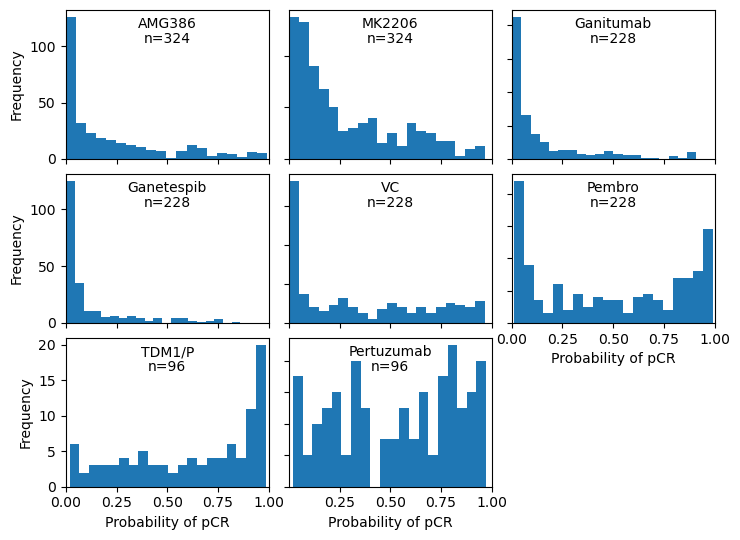

In [6]:
pCR_pred_samples ={}
fig, ax = plt.subplots(3,3, figsize=(7.5,5.5))
output_directory = 'res_xgb35_analysis/'
for ai, a in enumerate(arm_candidate):
    if a == 'TDM1/P':
        b = 'TDM1P'
    else:
        b = a
        
    #get gene expression and clinical data of one arm
    table2_a = table2[table2['Arm (short name)'] == a]
    gexp_a = gexp.loc[table2_a.index.values]
    pCR_a = table2_a['pCR']

    #get the hyperparmeters of the best XGBoost model for the arm
    file_name = 'res_xgb35/results_xgb35_hh1norm1_' + b +'_best_params.csv'
    xgb_params = pd.read_csv(file_name)
    xgb_params.set_index('Unnamed: 0', inplace = True)
    xgb_param = xgb_params.mean()
    xgb_param = xgb_param.to_dict()
    xgb_param['n_estimators'] = int(xgb_param['n_estimators'])
    xgb_param['max_depth'] = int(xgb_param['max_depth'])
    temp ={'n_jobs': 8, 'random_state': 100, 'objective':'binary:logistic'}
    xgb_param = xgb_param | temp

    #prepare training data
    y = pCR_a.values
    hh = 1  #if hh = 1, add HR and HER2 status as features
    fnorm = 1 #if fnorm = 1, normalize features
    if hh == 1:
        X_train = pd.concat([gexp_a, table2_a[['HR','HER2']]],axis = 1)
        X = X_train.values
    else:
        X = gexp_a.values 
    if fnorm == 1:
        sc = StandardScaler()
        sc.fit(X)
        X = sc.transform(X)

    #train a XGBoost modle for the arm
    xgb_clf =  XGBClassifier(**xgb_param)
    xgb_clf.fit(X,y)

    #Predict pCR on the test data of the two noncandidate arms
    if hh == 1:
        X = pd.concat([gexp_nc, table2_nc[['HR','HER2']]],axis = 1)
    else:
        X = gexp_nc
    if fnorm == 1:
        X = X.values
        X = sc.transform(X) 
    y_pred = xgb_clf.predict_proba(X)[:,1]
    df_ypred = pd.DataFrame(y_pred, index = gexp_nc.index.values, columns =['pCR proba'])

    #plot histgrams of predicted pCR probability 
    r, c = ai//3, ai%3
    nbins = 20
    if a in arm_candidate_her2n: #arms trained for HER2- type 
        df_ypred = df_ypred.loc[table2_nc[table2_nc['HER2']==0].index.values]
    elif a in arm_candidate_her2p: #arms trained for HER+ type
        df_ypred = df_ypred.loc[table2_nc[table2_nc['HER2']==1].index.values]  
        
    ax[r,c].hist(df_ypred['pCR proba'].values, bins = nbins)
    ax[r,c].set_xlim(0,1)
    ax[r,c].set_xlabel('Probability of pCR')
    if c ==0: ax[r,c].set_ylabel('Frequency')
    text_hpos = 0.5
    ax[r,c].text(text_hpos, 0.95, a, ha = 'center', va = 'top',transform=ax[r,c].transAxes) 
    temp = 'n='+str(df_ypred.shape[0])
    ax[r,c].text(text_hpos, 0.85, temp, ha = 'center', va = 'top',transform=ax[r,c].transAxes)

    if c != 0: 
        ax[r,c].set_yticklabels([])
    if r == 0:
        ax[r,c].set_xticklabels([])
    if r == 1 and c < 2: 
        ax[r,c].set_xticklabels([])
    if r == 2 and c ==1:
        ax[r,c].set_xticks([0.25, 0.50, 0.75,1.0])
    
    #Given a precision target, find the samples predicted to be responsive
    precision_target = [0.5, 0.6, 0.7, 0.8]
    file_name = output_directory + 'precall_' + b + '.csv'
    precall = pd.read_csv(file_name)
    precall.set_index('Unnamed: 0', inplace = True)

    pCR_samples1 = []
    for i in range(len(precision_target)):
        temp = precall[precall['precision']>=  precision_target[i]].index.min()
        proba_cutoff = precall.loc[temp, 'prob_threshold']
        temp1 = df_ypred[df_ypred['pCR proba']>=proba_cutoff].index.values
        pCR_samples1.append(list(temp1))
    pCR_pred_samples[a] = pCR_samples1

fig.tight_layout() 
fig.delaxes(ax[2, 2])
fig.subplots_adjust(wspace=0.1, hspace=0.1)

file_name = output_directory + 'fig_hist_pCR_proba.png'
plt.savefig(file_name )

In [7]:
# find the number of samples predicted to be pCR
temp = ['pCR rate'] + arm_candidate + ['all']
pCR_pred_samples_n = pd.DataFrame([], columns = temp)
pCR_pred_samples_n['pCR rate'] = precision_target
for i in range(len(precision_target)):
    pCR_pred_samples_unique = set()
    for a in arm_candidate:
        pCR_pred_samples_n.loc[i,a]=len(pCR_pred_samples[a][i])
        pCR_pred_samples_unique = pCR_pred_samples_unique.union(pCR_pred_samples[a][i]) 
    pCR_pred_samples_n.loc[i,'all'] = len(pCR_pred_samples_unique)
pCR_pred_samples_n

,pCR rate,AMG386,MK2206,Ganitumab,Ganetespib,VC,Pembro,TDM1/P,Pertuzumab,all
0,0.5,20,19,16,30,155,165,96,96,268
1,0.6,11,10,9,12,125,136,96,67,245
2,0.7,2,5,5,1,31,113,80,26,199
3,0.8,1,2,0,0,11,69,50,14,125


In [8]:
#save the predicted pCR results in a file 
pCR_pred_samples_n.set_index('pCR rate', inplace = True)
file_name = output_diretory + 'pCR_max.csv'
pCR_pred_samples_n.to_csv(file_name)
temp=pCR_pred_samples_n.T
file_name = output_diretory + 'pCR_maxT.csv'
temp.to_csv(file_name)

In [9]:
# Sample size in the test data
n_samples = pd.DataFrame([],columns =['HR-HER2-', 'HR-HER2+', 'HR+HER2-', 'HR+HER2+', 'total'])
n_samples.loc[0,'total']= table2_nc.shape[0]
for hr in [0,1]:
    temp = table2_nc[table2_nc['HR'] == hr]
    for her2 in [0,1]:
        i = 2*hr + her2
        n_samples.iloc[0,i] = temp[temp['HER2'] == her2].shape[0]
n_samples.index =['sample size']  
n_samples

,HR-HER2-,HR-HER2+,HR+HER2-,HR+HER2+,total
sample size,117,35,111,61,324
